In [4]:
"""
Written by Zain Eris Kamal (zain.eris.kamal@rutgers.edu).
Full repository available here: https://github.com/Humboldt-Penguin/Mars-Magnetics-Research
"""

import os

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RegularGridInterpolator

import zerisk.Utils as utils
import zerisk.DataDownloader as dd




class GRS:
    """
    Class allows you to:
        (1) Download GRS data, and 
        (2) Get elemental concetrations at exact coordinates by linearly interpolating between the four nearest points. 
            - Both exact concentration and volatile-adusted (normalized to an H20 and Si free basis) are available.
    
    See README in downloaded folder to find more information on the data itself.
    """
    






    ######################################################################
    ''' constant class variables '''

    nanval: float = -1e10
    # Value given to pixels where data is not defined (i.e. "NOT_APPLICABLE_CONSTANT"). In the data, this is 9999.999 (see lbl file).

    def getNanVal(self) -> float:
        '''
        Return value used for coordinates where GRS doesn't provide data.
        '''
        return self.nanval







    gdrive_url: str = r"https://drive.google.com/drive/folders/17ukcBhiLvy4fVUT10YvSxf25Et2Ovgah?usp=sharing"
    # URL from which latest dataset is downloaded using `DataDownloader.py`.

    











    ######################################################################
    ''' instance class variables '''
    # (if you're catching an AttributeError relating to one of these variables, it likely hasn't been assigned yet with something like `self.var=val``)



    path__datahome: str
    # Path from root to the directory within which the data folder either (1) already exists, or (2) will be downloaded.


    meta_dat: dict
    '''
    `meta_dat` is formatted as `meta_dat[element_name][quantity]`, where
        - `element_name` is from ['cl','fe','h2o','k','kvsth','si','th']
        - `quantity` is from:
            - 'concentration' = Concentration of the element. 
            - 'sigma' = The error associated with the concentration measurement. 
            - 'sigma_cfs' = The error associated with the concentration measurement. This error includes the errors associated with the correction factors applied to the concentration data if applicable. 

    Calling `meta_dat` as such gives a `scipy.interpolate._rgi.RegularGridInterpolator` object, which is a function that takes some [clon,lat] list and returns the linear interpolation of the original dataset to that coordinate.
    '''














    ######################################################################
    ''' main body '''
    
    
    
    
    
    def __init__(self) -> None:
        """
        Initialize empty GRS object (no data yet).
        """
        return
    
    
    
    
    
    
    def downloadData(self, path__datahome: str, overwrite: bool = False, verbose: bool = False) -> None:
        """
        DESCRIPTION:
        ------------
            Downloads and unzips data to `self.path__datahome` if it doesn't already exist there. If it already exists, overwrite if `overwrite==True`, else do nothing.
        
        PARAMETERS:
        ------------
            path__datathome : str
                Path from root to the directory within which the data folder either (1) already exists, or (2) will be downloaded.
            overwrite : bool
                If true and data folder already exists, delete the data folder and download again. Else skip the download and inform the user. 
            verbose : bool
                If true, print contents of unzipped data folder. Else do nothing. 
        """
        
        self.path__datahome = path__datahome
        dd.download_latest(path__datahome=self.path__datahome, data_name='GRS', url=self.gdrive_url, overwrite=overwrite, verbose=verbose)
        return
    



    
    
    
    def loadData(self) -> None:
        """
        DESCRIPTION:
        ------------
            Load crustal thickness data into `meta_dat` (dict). 

            `meta_dat` is formatted as `meta_dat[element_name][quantity]`, where
                - `element_name` is from ['cl','fe','h2o','k','kvsth','si','th']
                - `quantity` is from:
                    - 'concentration' = Concentration of the element. 
                    - 'sigma' = The error associated with the concentration measurement. 
                    - 'sigma_cfs' = The error associated with the concentration measurement. This error includes the errors associated with the correction factors applied to the concentration data if applicable. 

            Calling `meta_dat` as such gives a `scipy.interpolate._rgi.RegularGridInterpolator` object, which is a function that takes some [clon,lat] list and returns the linear interpolation of the original dataset to that coordinate.

        """
        self.meta_dat = {}

        path_folder = utils.getPath(self.path__datahome, 'GRS', 'smoothed')

        files = os.listdir(path_folder)

        for filename in files:
            if '.tab' not in filename: continue



            '''initialize entry in `meta_dat`'''
            element_name = filename[:filename.index('_')]
            self.meta_dat[element_name] = {}



            '''import data from files to np.ndarrays'''
            dat = np.loadtxt(utils.getPath(path_folder,filename))
            
            dat = np.where(dat == 9999.999, self.getNanVal(), dat)

            lat_range = np.unique(dat[:, 0])
            clon_range = np.unique(dat[:, 1])
            # lon_range = utils.clon2lon(clon_range)

            concentration = dat[:, 2].reshape(lat_range.shape[0], clon_range.shape[0]).T
            sigma = dat[:, 3].reshape(lat_range.shape[0], clon_range.shape[0]).T
            sigma_cfs = dat[:, 4].reshape(lat_range.shape[0], clon_range.shape[0]).T
            # NOTE on concentration/sigma/sigma_cfs indexing -- for index (i,j), `i` is longitude from left [0] to right [-1], `j` is latitude from bottom [0] to top [-1]



            '''processing/corrections'''
            if element_name == 'th':
                correction=0.000001 # correct ppm to concentration out of 1
            else:
                correction=0.01 # correct weight percent to concentration out of 1

            concentration = np.where(concentration != self.getNanVal(), concentration*correction, concentration)
            sigma = np.where(sigma != self.getNanVal(), sigma*correction, sigma)
            sigma_cfs = np.where(sigma_cfs != self.getNanVal(), sigma_cfs*correction, sigma_cfs)




            '''edge case: interpolation model does not work for edges where the map "wraps around" (i.e. lon bounds), so we duplicate one extra column on each edge of data/clon_range'''
            spacing = (360-clon_range[-1]) + (clon_range[0]-0)
            clon_range = np.array([clon_range[0]-spacing, *clon_range, clon_range[-1]+spacing])

            left_edge = concentration[0, :]
            right_edge = concentration[-1, :]
            concentration = np.array([right_edge, *concentration, left_edge])

            left_edge = sigma[0, :]
            right_edge = sigma[-1, :]
            sigma = np.array([right_edge, *sigma, left_edge])

            left_edge = sigma_cfs[0, :]
            right_edge = sigma_cfs[-1, :]
            sigma_cfs = np.array([right_edge, *sigma_cfs, left_edge])



            '''declare interpolation function'''
            self.meta_dat[element_name]['concentration'] = RegularGridInterpolator((clon_range, lat_range), concentration)
            self.meta_dat[element_name]['sigma'] = RegularGridInterpolator((clon_range, lat_range), sigma)
            self.meta_dat[element_name]['sigma_cfs'] = RegularGridInterpolator((clon_range, lat_range), sigma_cfs)







    def getConcentration(self, lon: float, lat: float, element_name: str, normalized: bool = True) -> float:

        if not normalized:
            clon = utils.lon2clon(lon)
            return self.meta_dat[element_name]['concentration']([clon,lat])[0]
        else:
            volatiles = ["cl", "h2o", "si"]
            if element_name in volatiles:
                raise Exception('Cannot normalize a volatile to a volatile-free basis.')

            raw = self.getConcentration(lon, lat, element_name, normalized=False)

            sum_volatile_concentration = 0

            for volatile in volatiles:
                volatile_concentration = self.getConcentration(lon, lat, volatile, normalized=False)
                if volatile_concentration < 0:
                    return self.getNanVal()
                sum_volatile_concentration += volatile_concentration

            return raw/(1-sum_volatile_concentration)

            
    def getSigma(self, lon: float, lat: float, element_name: str) -> float:
        clon = utils.lon2clon(lon)
        return self.meta_dat[element_name]['sigma']([clon,lat])[0]
            
    
    def getSigmaCFS(self, lon: float, lat: float, element_name: str) -> float:
        clon = utils.lon2clon(lon)
        return self.meta_dat[element_name]['sigma_cfs']([clon,lat])[0]
    








    def visualize(self, element_name: str, resolution: float, normalized: bool = True) -> None:
        dat = []

        lon_left = -180
        lon_right = 180
        lat_bottom = -75
        lat_top = 75


        for lat in np.arange(lat_bottom, lat_top, resolution):
            newline = []
            for lon in np.arange(lon_left, lon_right, resolution):

                '''modify this line to change value being plotted'''
                val = self.getConcentration(lon, lat, element_name, normalized)
                # val = grs.getSigma(lon, lat, element_name)

                newline.append(val)
            dat.append(newline)


        '''apply mask'''
        dat = np.asarray(dat)
        dat = np.ma.masked_where((dat <= 0), dat)



        '''primary plot'''
        fig = plt.figure(figsize=(10,7))
        ax = plt.axes()
        im = ax.imshow(dat[::-1], cmap='jet', extent=[lon_left, lon_right, lat_bottom, lat_top])

        '''titles'''
        ax.set_title(f'GRS {element_name} Abundance Map')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

        '''axis formatter'''
        ax.xaxis.set_major_formatter('{x}$\degree$')
        ax.yaxis.set_major_formatter('{x}$\degree$')


        '''x ticks'''
        '''Option 1: Set the spacing between x ticks'''
        # x_spacing = 60
        # ax.set_xticks(np.linspace(lon_left, lon_right, int((lon_right-lon_left)/x_spacing)+1))
        '''Option 2: Set the number of x ticks'''
        x_ticks = 7
        ax.set_xticks(np.linspace(lon_left, lon_right, x_ticks))

        '''y ticks'''
        '''Option 1: Set the spacing between y ticks'''
        # y_spacing = 25
        # ax.set_yticks(np.linspace(lat_bottom, lat_top, int((lat_top-lat_bottom)/y_spacing)+1))
        '''Option 2: Set the number of y ticks'''
        y_ticks = 7
        ax.set_yticks(np.linspace(lat_bottom, lat_top, y_ticks))

        '''color bar'''
        cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
        cbar = plt.colorbar(im, cax=cax)
        cbar.set_label(f'{element_name} Concentration [out of 1]', y=0.5)

        plt.show()

Data folder already exists at 
C:\Users\Eris\Documents\sync_local\01_Research\Mars_Magnetics\code\05_mag_src_map\src\data\1_raw\GRS. 
To overwrite, add `overwrite=True` param.



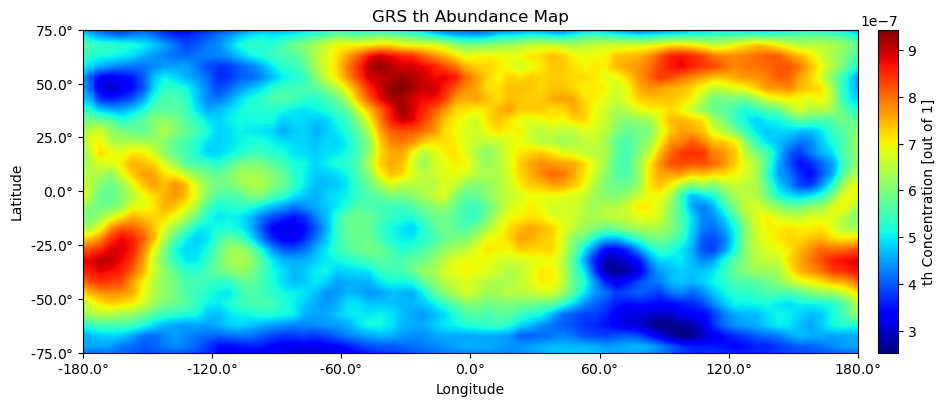

In [5]:
grs = GRS()
grs.downloadData(path__datahome=r'C:\Users\Eris\Documents\sync_local\01_Research\Mars_Magnetics\code\05_mag_src_map\src\data\1_raw', overwrite=False, verbose=True)
grs.loadData()

grs.visualize('th', resolution=1, normalized=False)